In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)


20.0

In [5]:
xs = np.arange(-5, 5, 0.25)

In [6]:
ys = f(xs)

In [8]:
ys.shape

(40,)

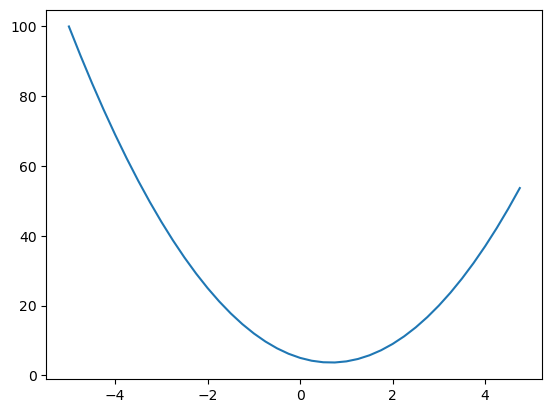

In [9]:
plt.plot(xs, ys)

In [14]:
h = 0.0000001
x = 2/3
slope = (f(x+h) - f(x))/ h

In [15]:
slope

2.9753977059954195e-07

In [17]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

# Create Value Object 

In [306]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        # value
        self.data = data
        # initial grad set to zero
        self.grad = 0.0
        # default _backward function
        self._backward = lambda: None
        # prev nodes, will be used in backpropagation
        self._prev = set(_children)
        # debugging variables
        self._op = _op
        self.label = label
        
    # addition
    def __add__(self, other):
        if (not isinstance (other, Value)):
            other = Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        if (not isinstance (other, Value)):
            other = Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance (other, (float, int))
        out = Value(self.data ** other, (self, ), f'**{other}')
        def _backward():
            self.grad += (other * (self.data) ** (other -1)) * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = ((math.exp(2*x)-1) / (math.exp(2*x)+1))
        out = Value(t, (self, ), 'tanh')
        def _backward():
          self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self, ), 'relu')
        def _backward():
            self.grad += (0 if self.data else self.data) * out.grad
        out._backward = _backward
        return out

        
    
    def __truediv__(self, other):
        return self * (other ** -1)

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    
    def __repr__(self):
        return f'Value(data={self.data})'

    def backward(self):
        topo = []
        visited = set()
        def build(root):
            if (root not in visited):
                visited.add(root)
                for child in root._prev:
                    build(child)
                topo.append(root)
        build(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        return None

In [307]:
a = Value(2)
b = Value(3)
a, b

(Value(data=2), Value(data=3))

In [308]:
d =  a * b * 2+ 4 * 2

In [309]:
d._prev, d._op, d
import torch

Differenciation
dL/dc = dL/dc * dc/dd    

d = f(x + h) - f(x) / h

# Using PyTorch


In [310]:
import torch
x1 = 2.0
w1 = -3.0
x2 = 0.0
w2 = 1.0
b = 6.8813735870195432

x1 = torch.tensor([x1], dtype=torch.float64, requires_grad=True)
x2 = torch.tensor([x2], dtype=torch.float64, requires_grad=True)
w1 = torch.tensor([w1], dtype=torch.float64, requires_grad=True)
w2 = torch.tensor([w2], dtype=torch.float64, requires_grad=True)
b = torch.tensor([b], dtype=torch.float64, requires_grad=True)

f = w1* x1 + w2* x2 + b
o = torch.tanh(f)

print(o)
# print(x1.grad.item(), x1.data.item())
# print(x2.grad.item(), x2.data.item())
# print(w1.grad.item(), w1.data.item())
# print(w2.grad.item(), w2.data.item())
# print(b.grad.item(), b.data.item())
# print(o.grad.item(), o.data.item())

o.backward()
print('---'* 20, 'after propagation')
print('x1', x1.grad.item(), x1.data.item())
print('x2', x2.grad.item(), x2.data.item())
print('w1', w1.grad.item(), w1.data.item())
print('w2', w2.grad.item(), w2.data.item())
print('b', b.grad.item(), b.data.item())
# print(o.grad.item(), o.data.item())
import random



tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
------------------------------------------------------------ after propagation
x1 -1.4999999999999998 2.0
x2 0.49999999999999994 0.0
w1 0.9999999999999999 -3.0
w2 0.0 1.0
b 0.49999999999999994 6.881373587019543



# Start Implementing Neural Network

In [333]:

class Module():
    def zero_grad(self):
        for each in self.parameters():
            each.grad = 0.0

    def parameters(self):
        return self.weights + [self.bias] + ['base_case called']

class Neuron(Module):
    def __init__(self, nin):
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.bias = Value(random.uniform(-1, 1))
    def __call__(self, x):        
        out = sum([wi * xi for wi, xi in zip(self.weights, x)], self.bias)
        t = out.tanh()
        return t
        
    def __repr__(self):
        return f'weight: {self.weights}, bias {self.bias}'
    def parameters(self):
        return self.weights + [self.bias]

class Layer(Module):
    def __init__(self, nin, out):
        print('Layer', nin, out)
        self.neurons = [Neuron(nin) for _ in range(out)]

    def parameters(self):
        params = []
        for each in self.neurons:
            params.extend(each.parameters())
        return params

    def __call__(self, x):
        out = [neuron(x) for neuron in self.neurons]
        return out[0] if len(out) == 1 else out
            
        

class MLP(Module):
    def __init__(self, nin, outs):
        layout = [nin] + outs
        self.layers = [Layer(layout[i], layout[i+1]) for i in range(len(outs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params


# [3, [4, 4, 1]]



In [334]:
# lo = MLP(3, [4, 4, 1])
# len(lo.parameters())
# lo
n = Neuron(4)
print(n([1,2,3,4]))

Value(data=0.6427234114804683)


In [335]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)


Layer 3 4
Layer 4 4
Layer 4 1


Value(data=0.8701041146406185)

In [336]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [365]:
for each in range(10000):
    # forward
    y_pred = [n(i) for i in xs]
    # print(list(zip(y_pred, ys)))
    
    # loss
    loss = sum([(yp - y)** 2 for yp, y in zip(y_pred, ys)])
    # zero_grad
    n.zero_grad()
    
    # backpropagation
    loss.backward()
    
    # step or update
    for each in n.parameters():
        each.data += -0.01 * each.grad
    print(loss)
    # print(y_pred)
    # print(ys)



Value(data=0.0011808137021479903)
Value(data=0.0011802863059106458)
Value(data=0.0011797593677187947)
Value(data=0.0011792328869830063)
Value(data=0.001178706863114846)
Value(data=0.0011781812955268833)
Value(data=0.0011776561836327006)
Value(data=0.001177131526846858)
Value(data=0.0011766073245849376)
Value(data=0.0011760835762634856)
Value(data=0.0011755602813000462)
Value(data=0.0011750374391131708)
Value(data=0.0011745150491223942)
Value(data=0.0011739931107482178)
Value(data=0.0011734716234121378)
Value(data=0.0011729505865366247)
Value(data=0.0011724299995451478)
Value(data=0.0011719098618621364)
Value(data=0.00117139017291298)
Value(data=0.0011708709321240898)
Value(data=0.0011703521389227873)
Value(data=0.001169833792737408)
Value(data=0.0011693158929972297)
Value(data=0.0011687984391325031)
Value(data=0.0011682814305744435)
Value(data=0.0011677648667552296)
Value(data=0.0011672487471079802)
Value(data=0.0011667330710667901)
Value(data=0.0011662178380666946)
Value(data=0.001165

In [367]:
y_pred

[Value(data=0.9939395412345805),
 Value(data=-0.9941663588458155),
 Value(data=-0.9915238829196947),
 Value(data=0.9919751358749498)]

-0.00683372498910572 0.4293003666495488
-0.01025058748365858 -0.7201213758707946
0.00341686249455286 0.09159497605420892
-0.00341686249455286 -0.7948067633270386
-0.006499164411791126 -0.2640609848604271
-0.009748746617686689 -0.4706138139770306
0.003249582205895563 0.783228778806183
-0.003249582205895563 0.29380113261676616
-0.010589123082549093 0.3798330769444516
-0.01588368462382364 0.29198578538883857
0.005294561541274547 0.8800874925783985
-0.005294561541274547 -0.30940829561201105
0.0436332147111977 -0.5861645415594683
0.06544982206679656 -0.06756839135096143
-0.02181660735559885 -0.719449657401849
0.02181660735559885 -0.51622152073534
-0.009071009308951451 -0.008525681894058595
-0.009158729872643932 -0.5881383207256589
0.003894840990230902 0.14053923183944037
-0.007672744105675571 0.613968578815212
0.009301983696165996 0.847582637834288
0.03267817784479927 -0.2618409685310829
0.032994189887490054 0.9393736032863118
-0.014031107478897714 -0.3852323019305826
0.027640947980890614 0

In [325]:
y_pred, ys

([[Value(data=0.7483250655636049)],
  [Value(data=0.7483250655636049)],
  [Value(data=0.7483250655636049)],
  [Value(data=0.7483250655636049)]],
 [1.0, -1.0, -1.0, 1.0])